In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [17]:
df_train = pd.read_excel("AI_vs_huam_train_dataset.xlsx")
df_test = pd.read_csv("Final_test_data.csv")

In [18]:
def get_wordnet_pos_tag(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN


def text_process(tweet):
  if not isinstance(tweet, str) or not tweet.strip():
        return ""

  try:
      lemmatizer = WordNetLemmatizer()
      stop_words = set(stopwords.words('english'))

      tweet = tweet.lower()

      tweet = tweet.translate(str.maketrans('', '', string.punctuation + string.digits))

      tokens = word_tokenize(tweet)

      pos_tags = pos_tag(tokens)

      processed_tokens = []
      for word, tag in pos_tags:
          if len(word) > 1 and word not in stop_words:
              pos = get_wordnet_pos_tag(tag)
              lemma = lemmatizer.lemmatize(word, pos=pos)
              processed_tokens.append(lemma)

      return " ".join(processed_tokens)

  except Exception as e:
      print(f"error: {e}")
      return ""

In [10]:
df_train['lematized_tweets'] = df_train['essay'].apply(text_process)
df_test['lematized_tweets'] = df_test['essay'].apply(text_process)

In [11]:
X = df_train['lematized_tweets']
y = df_train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, SimpleRNN, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)


In [63]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [64]:
def create_cnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NB_WORDS,
                        output_dim=EMBEDDING_DIM,
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=True))  # 使用随机初始化的词向量
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # 关键：二分类 sigmoid
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [71]:
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NB_WORDS,
              output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # 二分类
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [72]:
def create_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NB_WORDS,
              output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True))
    model.add(SimpleRNN(64))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # 二分类
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

def train_evaluate_dl_model(model, X_train, y_train, X_test, y_test,
                            epochs=10, batch_size=32, labels=('Human', 'AI')):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # 训练模型
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[early_stopping],
                        verbose=1)

    # 绘制训练过程
    plt.figure(figsize=(12, 4))

    # 准确率图
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 损失图
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 测试集评估
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype("int32")

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 打印分类报告
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=labels))

    return {
        'accuracy': accuracy,
        'loss': loss,
        'model': model
    }


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.5894 - loss: 0.6580 - val_accuracy: 0.8361 - val_loss: 0.3226
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.9288 - loss: 0.2204 - val_accuracy: 0.9398 - val_loss: 0.1391
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.9914 - loss: 0.0516 - val_accuracy: 0.9565 - val_loss: 0.1164
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9991 - loss: 0.0138 - val_accuracy: 0.9498 - val_loss: 0.1187
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9982 - loss: 0.0081 - val_accuracy: 0.9532 - val_loss: 0.1187
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9565 - val_loss: 0.1165


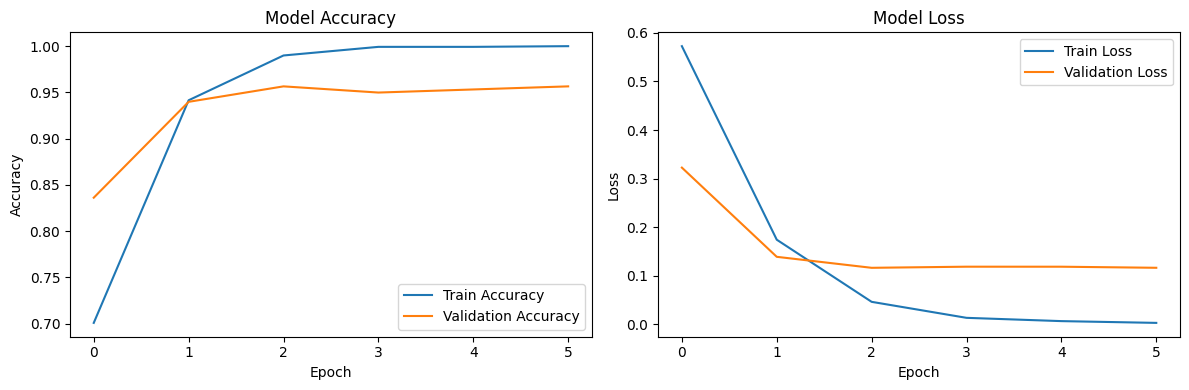

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


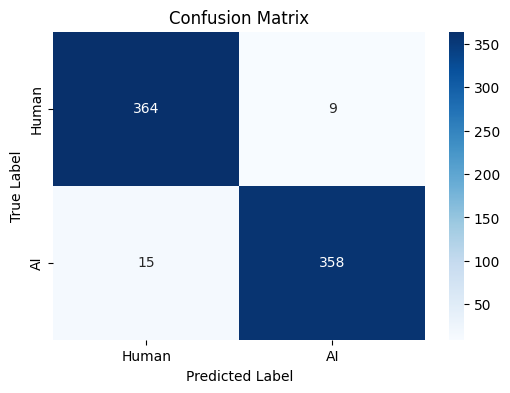

Classification Report:

              precision    recall  f1-score   support

       Human       0.96      0.98      0.97       373
          AI       0.98      0.96      0.97       373

    accuracy                           0.97       746
   macro avg       0.97      0.97      0.97       746
weighted avg       0.97      0.97      0.97       746



In [68]:
cnn_model = create_cnn_model()
results_cnn = train_evaluate_dl_model(cnn_model, X_train_pad, y_train_enc, X_test_pad, y_test_enc)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 36s 339ms/step - accuracy: 0.5733 - loss: 0.6502 - val_accuracy: 0.8997 - val_loss: 0.3030
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 320ms/step - accuracy: 0.9489 - loss: 0.1738 - val_accuracy: 0.9264 - val_loss: 0.1901
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - accuracy: 0.9863 - loss: 0.0579 - val_accuracy: 0.9365 - val_loss: 0.2447
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.9928 - loss: 0.0271 - val_accuracy: 0.9298 - val_loss: 0.2448
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 308ms/step - accuracy: 0.9969 - loss: 0.0151 - val_accuracy: 0.9365 - val_loss: 0.2857
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 308ms/step - accuracy: 0.9969 - loss: 0.0159 - val_accuracy: 0.9498 - val_loss: 0.2374
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 304ms/step - accuracy: 0.9993 - loss: 0.0057 - val_accuracy: 0.9365 - val_loss: 0.3103
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 304ms/step - accuracy: 0.9994 - loss: 0.0055 - val_accu

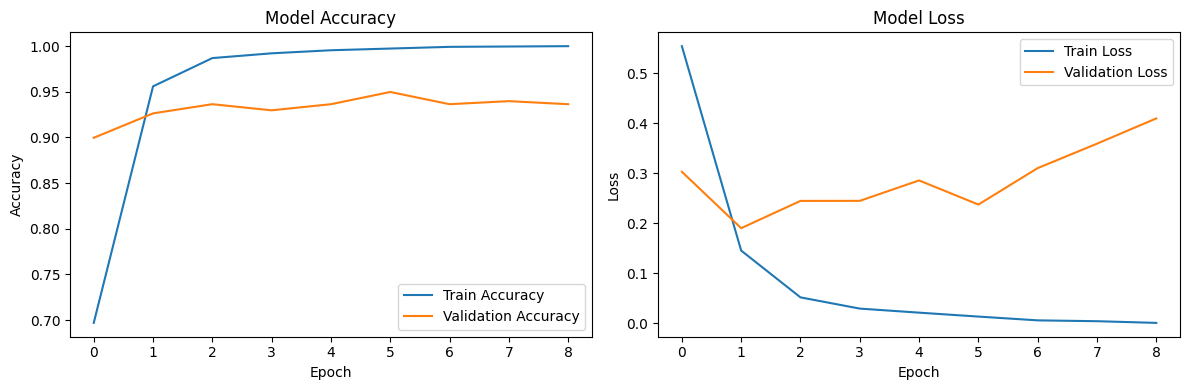

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


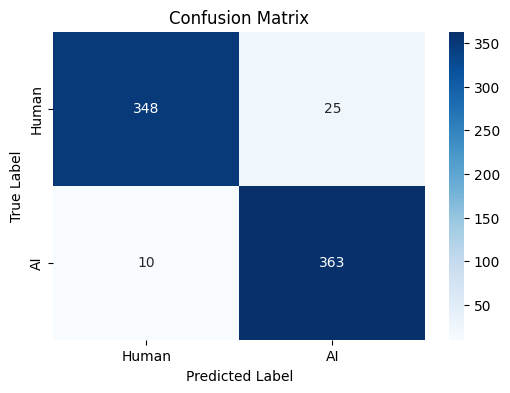

Classification Report:

              precision    recall  f1-score   support

       Human       0.97      0.93      0.95       373
          AI       0.94      0.97      0.95       373

    accuracy                           0.95       746
   macro avg       0.95      0.95      0.95       746
weighted avg       0.95      0.95      0.95       746



In [73]:
lstm_model = create_lstm_model()
results_lstm = train_evaluate_dl_model(lstm_model, X_train_pad, y_train_enc, X_test_pad, y_test_enc)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.4909 - loss: 0.7000 - val_accuracy: 0.5318 - val_loss: 0.6924
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.6592 - loss: 0.6381 - val_accuracy: 0.7592 - val_loss: 0.5300
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.9163 - loss: 0.2582 - val_accuracy: 0.7191 - val_loss: 0.5689
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.8098 - loss: 0.4041 - val_accuracy: 0.9164 - val_loss: 0.2173
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.9885 - loss: 0.0454 - val_accuracy: 0.9431 - val_loss: 0.1912
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.9925 - loss: 0.0299 - val_accuracy: 0.9231 - val_loss: 0.2328
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.9961 - loss: 0.0172 - val_accuracy: 0.8930 - val_loss: 0.3749
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9955 - loss: 0.0163 - val_accuracy: 0.9164 - 

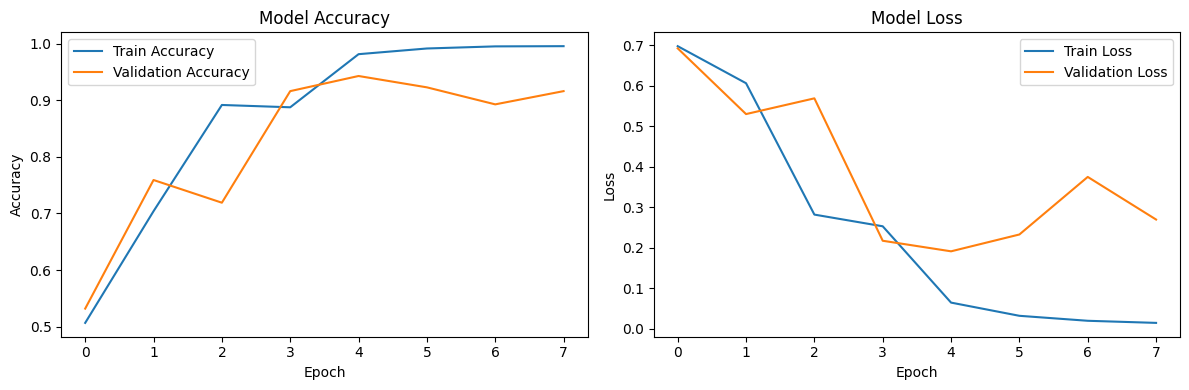

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


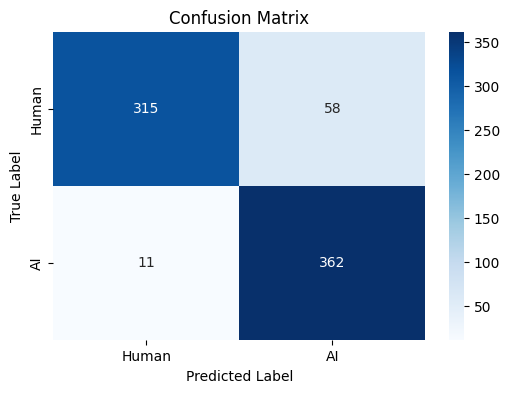

Classification Report:

              precision    recall  f1-score   support

       Human       0.97      0.84      0.90       373
          AI       0.86      0.97      0.91       373

    accuracy                           0.91       746
   macro avg       0.91      0.91      0.91       746
weighted avg       0.91      0.91      0.91       746



In [74]:
rnn_model = create_rnn_model()
results_rnn = train_evaluate_dl_model(rnn_model, X_train_pad, y_train_enc, X_test_pad, y_test_enc)

In [76]:
cnn_model.save("cnn_model.keras")
rnn_model.save("rnn_model.keras")
lstm_model.save("lstm_model.keras")
